In [21]:
import os
import shutil
import time
from datetime import timedelta
from importlib import reload
from pathlib import Path

import numpy as np
import tensorflow as tf
from IPython.display import display, clear_output
from tqdm import tqdm

import solver; reload(solver)
import initializers; reload(initializers)
import plotter; reload(plotter)

%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [11]:
# some directories definition
base_dir = '/Users/IllarionK/Projects/master_degree'
if not os.path.exists(base_dir):
    base_dir = '/src'
frames_dir = os.path.join(base_dir, 'frames')
os.makedirs(frames_dir, exist_ok=True)
video_dir = os.path.join(base_dir, 'videos')
os.makedirs(video_dir, exist_ok=True)

## Variables definition

In [34]:
SECONDS_TO_SIMULATE = 100
NORM_LENGTH_X = 4
NORM_LENGTH_Y = 1
SCALE = 100
LENGTH_X  = NORM_LENGTH_X * SCALE
LENGTH_Y  = NORM_LENGTH_Y * SCALE
N_STEPS = SECONDS_TO_SIMULATE * SCALE

### Object parameters
# X.shape: (LENGTH_Y, LENGTH_X) Y shape: (LENGTH_Y, LENGTH_X)
X, Y = np.meshgrid(range(LENGTH_X), range(LENGTH_Y))
# INFO: shape the same as all space, but only partially filled with object
NORM_CYLINDER_RADIUS = 0.125
CYLINDER_RADIUS = int(NORM_CYLINDER_RADIUS * SCALE)
# True within object boundaries
Y_SHIFT = 0
OBJECT_MASK = (X - LENGTH_X / 4) ** 2 + (Y - LENGTH_Y / 2 + Y_SHIFT) ** 2 < (CYLINDER_RADIUS) ** 2

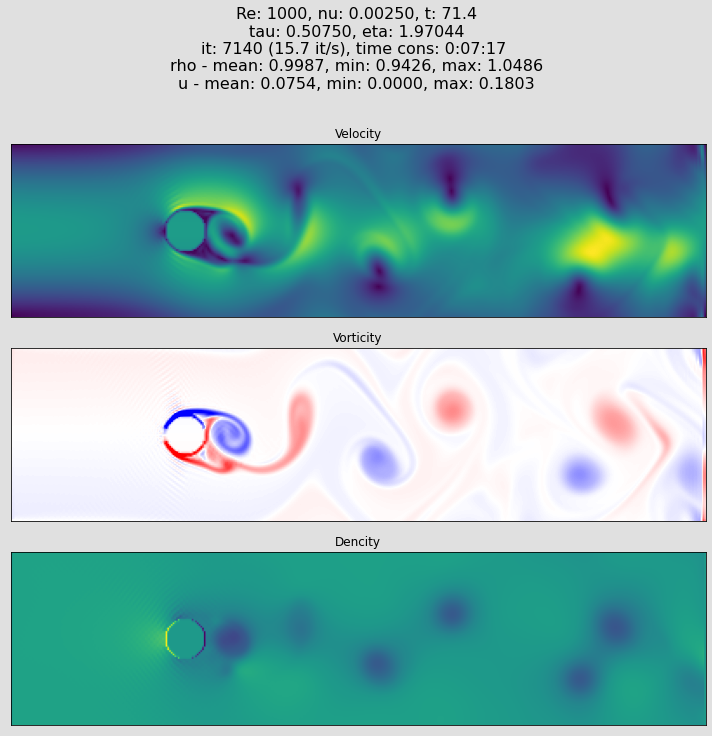

In [ ]:
REs = [10, 60, 100, 200, 500, 1000][::-1]
REs = [1000]
PLOT = True
SAVE_RES = False
for RE in REs:
    nu, tau, omega = initializers.calc_init_params(
        scale=SCALE,
        Re=RE,
        D=NORM_CYLINDER_RADIUS * 2,
    )
    print(f"nu: {nu}")
    print(f"tau: {tau}")
    print(f"omega: {omega:.5f}")

    def prep_figure():
        fig, axes = plt.subplots(3, figsize=(10, 11))
        fig.patch.set_facecolor('#E0E0E0')
        fig.suptitle(f'Re: {RE}', fontsize=16)
        for ax in axes:
            ax.invert_yaxis()
            ax.get_xaxis().set_visible(False)
            ax.get_yaxis().set_visible(False)
            ax.set_aspect('equal')
        fig.tight_layout()
        return fig, axes
    
    bwr_cmap = plt.cm.bwr.copy()
    bwr_cmap.set_bad('black')
    
    if PLOT:
        fig, axes = prep_figure()
    if SAVE_RES:
        res_frame_dir = os.path.join(frames_dir, f"{RE}_{SCALE}")
        if os.path.exists(res_frame_dir):
            shutil.rmtree(res_frame_dir)
        os.makedirs(res_frame_dir, exist_ok=True)

    F = initializers.init_poiseuille(
        length_x=LENGTH_X,
        length_y=LENGTH_Y
    )
    first_col = np.copy(F[:, 0, :])
    last_col = np.copy(F[:, -1, :])
    wide_F = np.zeros((F.shape[0] + 2, F.shape[1] + 2, 9))
    start = time.time()
    global_start_time = time.time()
    
    for it in tqdm(range(N_STEPS), disable=(PLOT or SAVE_RES)):
        F = solver.calc(
            F, wide_F,
            obj_mask_np=OBJECT_MASK.astype(np.uint8),
            tau=tau,
        )
        # TODO: move this inside calculation method
        # TODO: or fix copied columns at the wide_F
        F[:, 0, :] = first_col
        F[:, -1, :] = last_col

        if (it % (SCALE / 5) == 0 or it == N_STEPS - 1) and (PLOT or SAVE_RES):
            end = time.time()
            plot_it_per_sec = 10 / (end - start)
            start = end
            time_cons = str(timedelta(seconds=time.time() - global_start_time)).split(".")[0]
            if SAVE_RES:
                fig, axes = prep_figure()
            plot_results = plotter.pre_plot(F)
            titles = ['Velocity', 'Vorticity', 'Dencity']
            cmaps = [None, bwr_cmap, None]

            u, vorticity, rho = plot_results
            fig.suptitle(
                (
                    f"Re: {RE}, nu: {nu:.5f}, t: {it / SCALE:.1f}"
                    f"\ntau: {tau:.5f}, eta: {1 / tau:.5f}"
                    f"\nit: {it} ({plot_it_per_sec:.1f} it/s), time cons: {time_cons} "
                    f"\nrho - mean: {np.mean(rho):.4f}, min: {np.min(rho):.4f}, max: {np.max(rho):.4f}"
                    f"\nu - mean: {np.mean(u):.4f}, min: {np.min(u):.4f}, max: {np.max(u):.4f}"
                ),
                fontsize=16)
            fig.tight_layout()
            for ax, title, img, cmap in zip(axes, titles, plot_results, cmaps):
                ax.cla()
                ax.set_title(f"{title}")
                ax.imshow(img, cmap=cmap)
                if title == 'Vorticity':
                    ax.get_images()[0].set_clim(-.1, .1)

            if PLOT:
                display(fig)
            clear_output(wait=True)
            if SAVE_RES:
                pylab.savefig(
                    os.path.join(res_frame_dir, str(it)),
                    facecolor=fig.get_facecolor(),
                    transparent=False
                )
            plt.pause(0.001)
